### Group #21: Haofeng Li, Sangrok Lee and Shardul Rane

# To What Extent Does "Trade War" Affect Businesses

In [1]:
# pip install pandas_datareader

In [2]:
# pip install mpl_finance

In [3]:
# pip install plotly

In [5]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib import style
%matplotlib inline
import pandas_datareader as web
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import datetime
import pandas as pd
import matplotlib.dates as mdates
import plotly.express as pe
import requests
import bs4 as bs
import time
import PyQt5
import numpy as np
import os
import sqlite3
from sqlite3 import Error
import PyQt5

plt.rcParams['figure.figsize'] = [40, 20]
plt.rcParams.update({'font.size': 18})

style.use('seaborn-ticks')
style.use('dark_background')

import warnings
warnings.filterwarnings(action='ignore')

#### Important Note: The Libraries used are to be installed within the python 3 environment for the code to execute.

In [6]:
class scrape1:

    def web(self,industry):

        req = requests.get('https://www.forbes.com/global2000/list/#tab:overall')
        bsoup = bs.BeautifulSoup(req.text, features="lxml")
        table = bsoup.find('table')
        company = []
        # print(table)
        for row in table.findAll('td'):

            company = row.findAll('td',{"class":"name"})
    
        return table
        #store the companies in the separate database
        
    def createDB(self,db_file,delete_db=True):
        
        # The creation of database to store tables
        # 1. The Stock prices for the S&P 500 companies
        # 2. The second database stores the dates where any particular announcement regarding the US - China policy occured 
        # 3. The stock prices for all the comapnies to be analysed - the data is crawled using the wikipedia scraping and the yahoo api   
        
        try:
            conn = sqlite3.connect(db_file)
            return conn
        except Error as e:
                print(e)

    def SP_database(self,company,start,end):
        
        # This function creates the Database for stock market index S&P 500 if not present else it fetched the stock prices from the table 
        # for the given time period
        # For the first run the functinon reuqires tp be called 2 times - the database is created and the function needs to be called again to fetch the data 
        
        start = start
        end = end

        
        if os.path.exists('SPdb.db'):

            SPdb = sqlite3.connect('SPdb.db')
            dfSP = pd.read_sql_query("SELECT * FROM " + str(company).strip('^') + " WHERE Date BETWEEN '" +str(start)+ "' AND '" +str(end)+"'", SPdb)
            
            return dfSP
        
        elif not os.path.exists('SPdb.db'):
            try:
                SPdb = sqlite3.connect('SPdb.db')
            except Error as e:
                print(e)
            df = web.DataReader(company, 'yahoo', start, end)
            
            # The stock prices are very volatile when for the daily change. Thus the 100 moving average is calculated to smooth out the data  
            
            df['100ma'] = df['Adj Close'].rolling(window=100).mean()
            df.dropna(inplace=True)
            df.to_sql(str(company).strip('^'), SPdb, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None,
                          method=None)
            
            SPdb.commit()
            return df    
        

    def sp500_data(self,company,start,end):
        
        # The function crawls the wikipedia page to identify the tickers for a company and then stores them in a list whichh then 
        # is used to query the yahoo api and the results are stored in the separate table
        
        start_default = start
        end_default = end
        reque = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
        soup = bs.BeautifulSoup(reque.text, 'lxml')
        pgtable = soup.find('table', {'class': 'wikitable sortable'})
        ticks = ['TSLA','X']
        companies = ['TSLA','F','BA','FCX','GM','X','AAPL','GOOGL']
        
        for row in pgtable.findAll('tr')[1:]:
            
                tick = row.findAll('td')[0].text
                if tick.strip('\n') in companies:
                    ticks.append(tick.strip('\n'))
        
      
        if os.path.exists('sp500.db'):

            print('Already DB present')
            connec500 = sqlite3.connect('sp500.db')
            df = pd.read_sql_query("SELECT * FROM " + company + " WHERE Date BETWEEN '" +str(start_default )+ "' AND '" +str(end_default)+"'", connec500)
            
            return df

        elif not os.path.exists('sp500.db'):
            try:
                connec500 = sqlite3.connect('sp500.db')
            except Error as e:
                print(e)
            for names in ticks:
                time.sleep(5)
                
                df = web.DataReader(names, 'yahoo', start_default, end_default)
                df['100ma'] = df['Adj Close'].rolling(window=100).mean()
                df.dropna(inplace=True)
                df.to_sql(names, connec500, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None,
                          method=None)
                connec500.commit()
            #     
            # connec501 = sqlite3.connect('sp500.db')
            # 
            # df = pd.read_sql_query("SELECT * FROM " + company + " WHERE Date BETWEEN '" +str(start_default )+ "' AND '" +str(end_default)+"'",
            #                        connec501)

            print("Data base created please execute again now")

In [7]:
db_file = "SPdb.db"
def createDBDate(db_file):
        # This function creates the database which stores the important dates which are used to identify the stock impact on each company
        try:
            connDate = sqlite3.connect(db_file)
            
        except Error as e:
                print(e)
        # create an array of 5 dates starting at '2015-02-24', one per day
        rng = pd.date_range('2019-02-24', periods=20, freq='10D')
        df = pd.DataFrame({ 'Date': rng, 'Val' : np.random.randn(len(rng))})
        
        df.to_sql('Dates', connDate , if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None,method=None)
        
        return df

In [8]:
def dropPoints():
    # the database for the dates and the company stock market data is then compared together using the inner join within the 
    # sqlite database of the S&P500 database to display the effect of the trade tarrifs based on the dates   
    
    
    SP500Con = sqlite3.connect("SPdb.db")
    cursor = SP500Con.cursor()
    cursor.execute("""SELECT *
                       FROM GSPC
                       JOIN Dates
                       ON GSPC.Date= Dates.Date
                       """)
    ViewData = cursor.fetchall()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
    SP500Con.commit()
    date = []
    moving = []
    for i in ViewData:
        date.append(i[0])
        moving.append(i[4])    
    return date, moving

## S&P 500 (^GSPC)
### is a stock market index that tracks the stocks of 500 large-cap U.S. companies

In [9]:
import matplotlib

def plotSingle(scrapeObj,start,end,company):
    
        # The function reads the data from the sql table within the given date range and plots the candle stick graphs for the  
        # s&P stock and the each company under the analysis
        
        
        fig = plt.figure()
        fig.subplots_adjust(hspace=1.4)
        #the first arg is row*col second one is starting point for the graphs
        
        scraoeObj = scrapeObj
        if(company == "^GSPC"):
            
            df2 = scrapeObj.SP_database(company,start,end)
            df2 = df2.set_index(pd.DatetimeIndex(df2['Date']))
            df2['100ma'] = df2['Adj Close'].rolling(window=100).mean()

            df2.dropna(inplace=True)


            # The adjusted close and the vloume is sampled to the 10 days data to take under consideeration that any effect of the tarrif 
            # are only reflected after a certain amount of time

            df_ohlc = df2['Adj Close'].resample('10D').ohlc()
            df_volume = df2['Volume'].resample('10D').sum()

            df_ohlc.reset_index(inplace=True)


            df_ohlc['Date'] = pd.to_datetime(df_ohlc['Date']).dt.date
            df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)


            ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
            ax2 = plt.subplot2grid((6, 1), (5, 0), rowspan=1, colspan=1, sharex=ax1)
            ax1.xaxis_date()

            candlestick_ohlc(ax1, df_ohlc.values, width=5, colorup='g')
            ax1.plot(df2.index, df2['Adj Close'],linewidth= 0.5)

            ax1.title.set_text(company + ' Stock Performance')
            ax1.set_xlabel('Date Range')
            ax1.set_ylabel('Stock Price')

            ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0,facecolor='g')
            ax2.title.set_text(company + ' Stock Volume')
            ax2.set_xlabel('Date Range')
            ax2.set_ylabel('Stock Volume')
            fig=plt.figure(figsize=(60, 60), dpi= 80, facecolor='w', edgecolor='k')
            
        else:   
            df2 = scrapeObj.sp500_data(company,start,end)
        

In [10]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 11, 11)
company = 'TSLA'
scrapeObj = scrape1()
plotSingle(scrapeObj,start,end,company)

Already DB present


<Figure size 2880x1440 with 0 Axes>

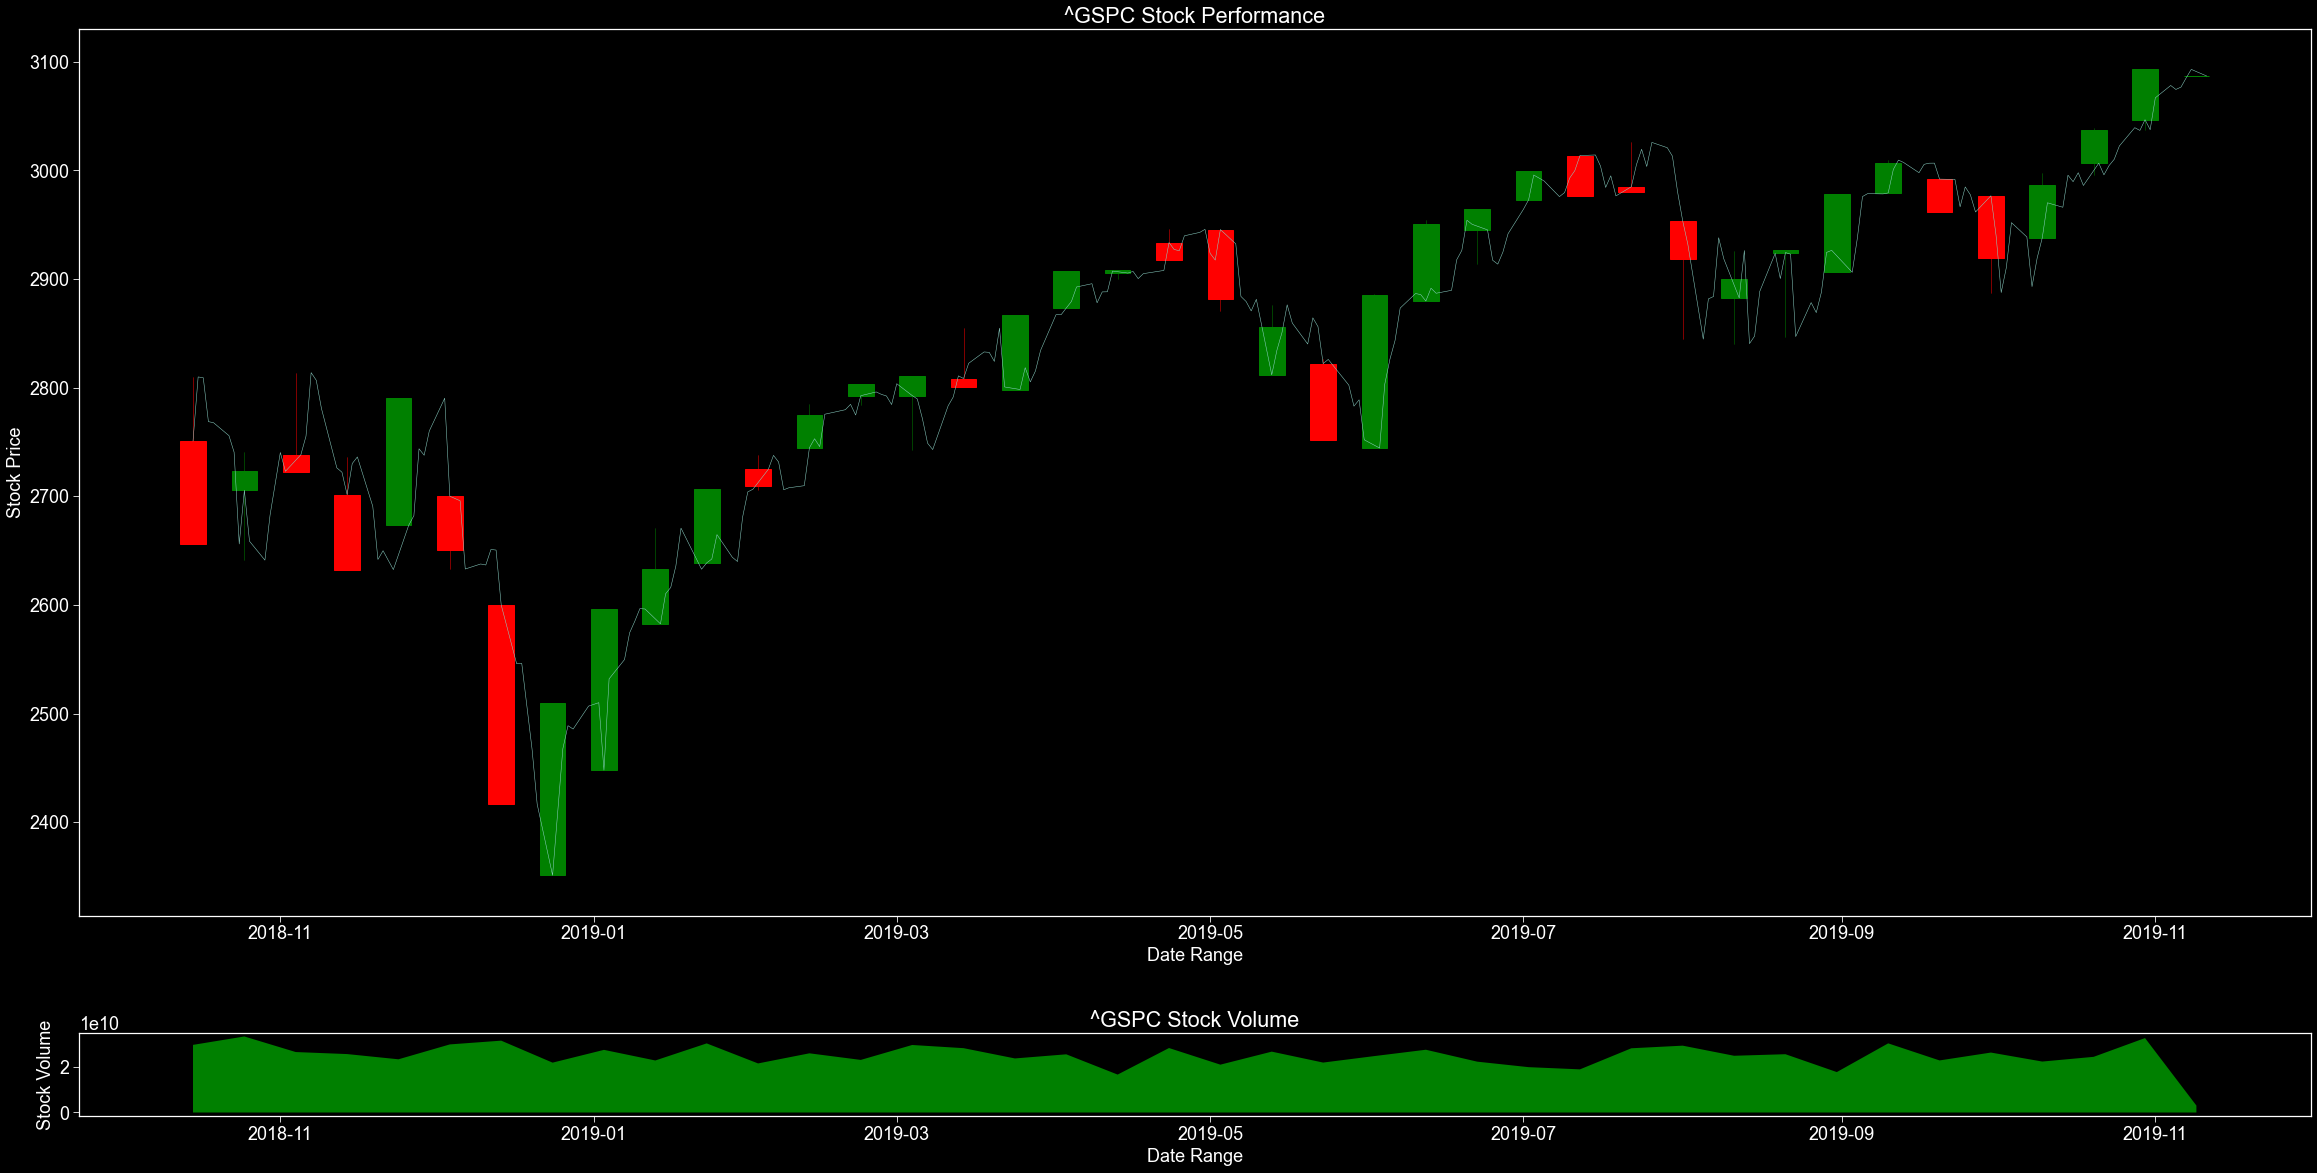

<Figure size 4800x4800 with 0 Axes>

In [11]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 11, 11)
company = '^GSPC'
scrapeObj = scrape1()
plotSingle(scrapeObj,start,end,company)

#### Important Note: please run twice and refresh page and run it again (for MAC)

In [12]:
db_file = "SPdb.db"
createDBDate(db_file)

,Date,Val
0,2019-02-24,-1.922236
1,2019-03-06,1.327911
2,2019-03-16,-2.136282
3,2019-03-26,0.613445
4,2019-04-05,1.450290
5,2019-04-15,1.816641
6,2019-04-25,0.146486
7,2019-05-05,-0.224655
8,2019-05-15,0.472551
9,2019-05-25,-0.581111


#### It shows the trend line and bars (green means average stock prices increased and red means average stock prices decreased) from November 2018 to November 2019. Generally, average stock prices increased, but there are sudden drops of average stock. These brought our attention if these caused by trade war.

In [13]:
def plotDrop(scrapeObj,start,end,company):

        fig = plt.figure()
        fig.subplots_adjust(hspace=1.4)
        #the first arg is row*col second one is starting point for the graphs
    
        scraoeObj = scrapeObj
        if(company == "^GSPC"):
            
            df1 = scrapeObj.SP_database(company,start,end)
            
        else:
            df1 = scrapeObj.sp500_data(company,start,end)
        
        df1 = df1.set_index(pd.DatetimeIndex(df1['Date']))
        df1.dropna(inplace=True)
        
        df_ohlc = df1['Adj Close'].resample('2D').ohlc()
        
        df_ohlc.reset_index(inplace=True)
        df_ohlc['Date'] = pd.to_datetime(df_ohlc['Date']).dt.date
        df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
        
        ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
        ax1.xaxis_date()
        
        x,y = dropPoints()
        ax1.scatter(x, y,s=300)
        ax1.plot(df1.index, df1['Adj Close'],linewidth= 2)
        ax1.title.set_text(company + ' Stock Performance')
        ax1.set_xlabel('Date Range')
        ax1.set_ylabel('Stock Price')
        
        plt.show()

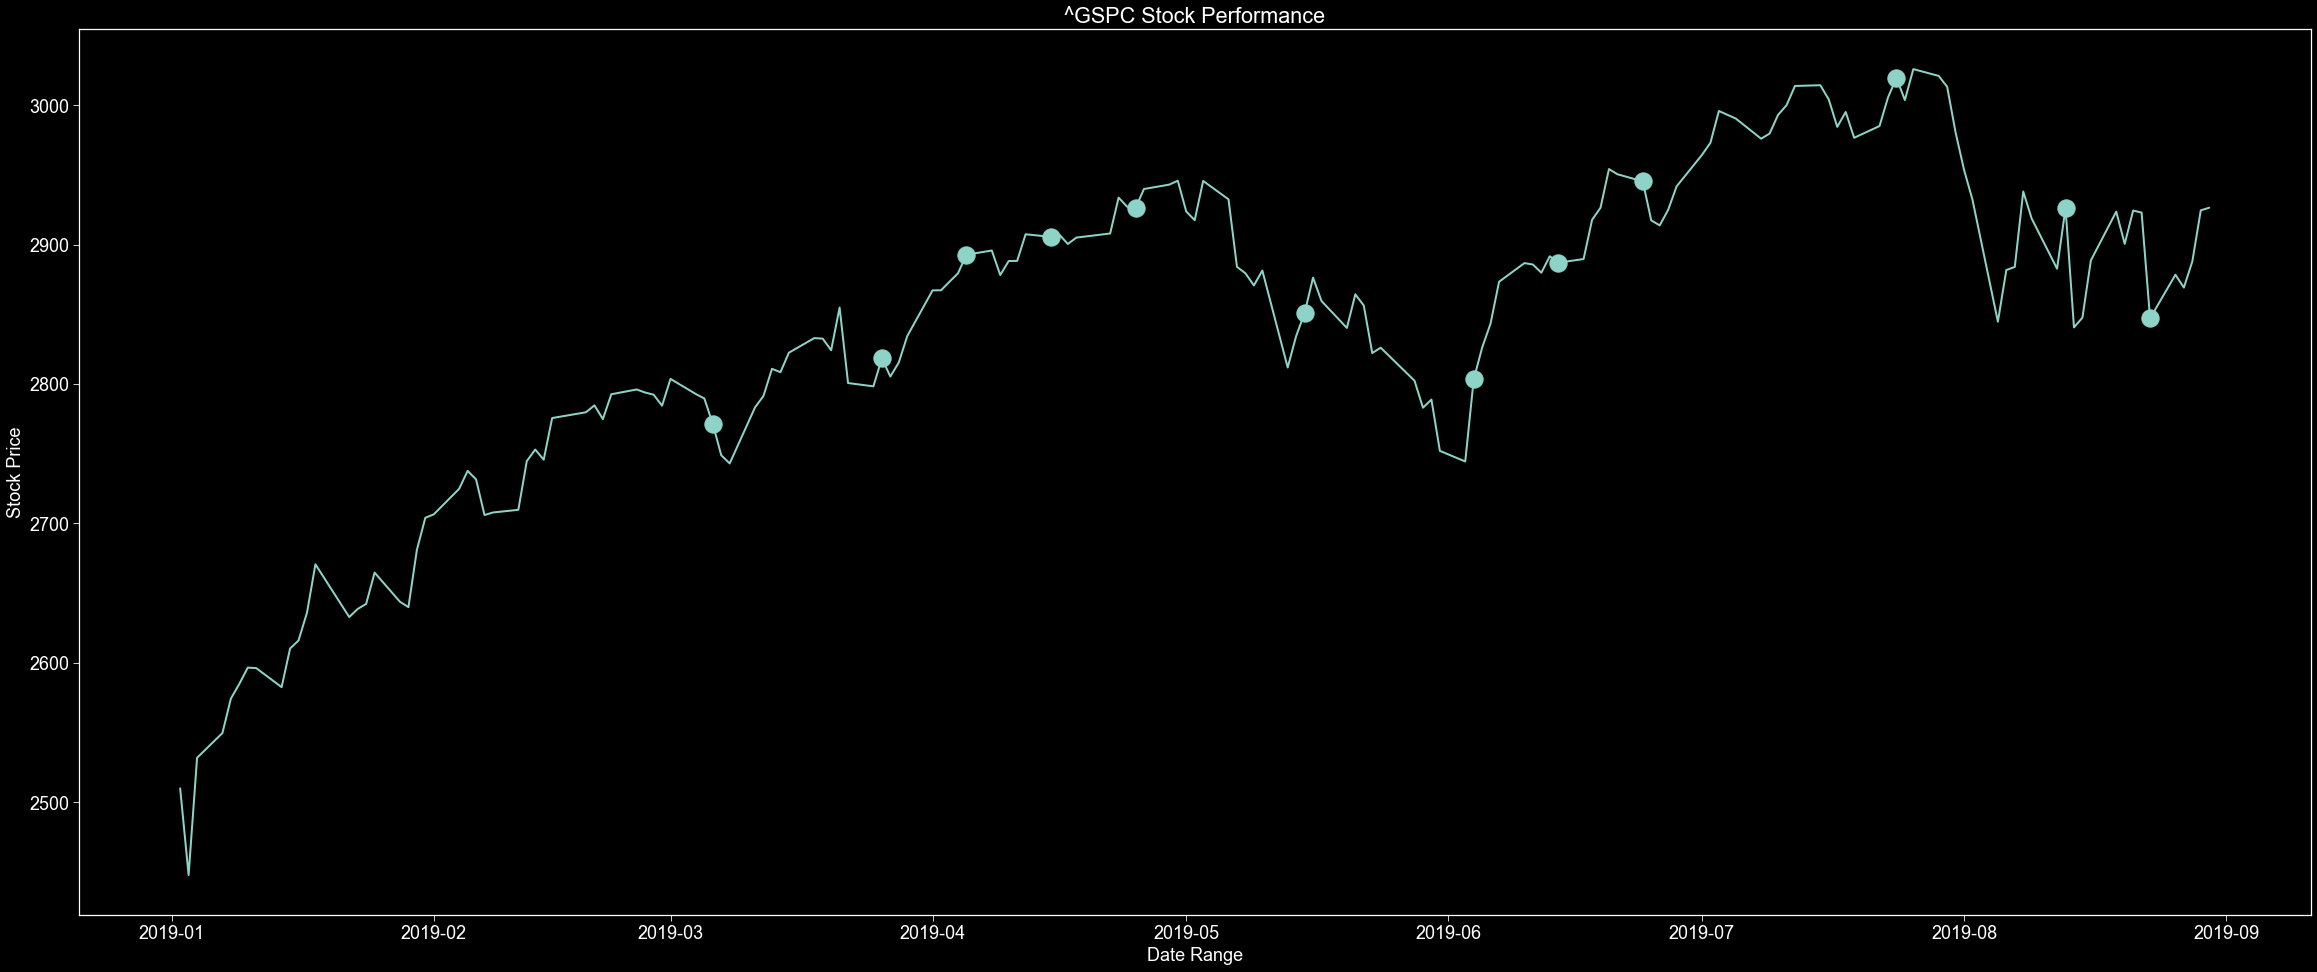

In [14]:
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 8, 30)
company = '^GSPC'
scrapeObj = scrape1()
plotDrop(scrapeObj,start,end,company)

#### It shows S&P 500 (^GSPC) with dates that President Trump imposed tariffs on imported goods (dot). Generally, when president imposes tax on imported goods, the trend line or stock prices slightly or dramatically decreases, but there are some trend line that increases. We think that there are companies that took advantage of trade war but mostly, we predict most companies suffered.

#### We noticed S&P 500 (^GSPC) drops or rises when president imposes the tax. We want to know which business sectors suffered or took advantage from the tariffs.

## Industries that Most Exposed to Chinese Exports

In [15]:
def countryIndustry(path):
    countryData = pd.read_excel(path)
    try:
        connec500 = sqlite3.connect('sp500.db')
    except Error as e:
        print(e)
    
    countryData.to_sql(str(path).strip('.xlsx'), connec500, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None,
                  method=None)
    connec500.commit()
    countryData = pd.read_sql_query("SELECT * FROM " + str(path).strip('.xlsx'), connec500)
    
    countries = countryData['Country']
    
    Energy = np.array(countryData['Energy'])
    Mining = np.array(countryData['Mining'])
    Chemical_Products = np.array(countryData['Chemical Products'])
    Metal = np.array(countryData['Metal'])
    Electronics = np.array(countryData['Electronics'])
    Transport = np.array(countryData['Transport'])
    Machinery = np.array(countryData['Machinery'])
    
    ind = [country for country in countries]
 
    x1 = plt.bar(ind, Energy, width=0.6, label='golds', color='gold', bottom=Energy+Mining+Metal+Electronics+Transport+Machinery)
    x2 = plt.bar(ind, Mining, width=0.6, label='silvers', color='silver', bottom=Chemical_Products+Metal+Electronics+Transport+Machinery)
    x3 = plt.bar(ind, Chemical_Products, width=0.6, label='bronzes', color='#CD7F32', bottom=Metal+Electronics+Transport+Machinery)
    x4 = plt.bar(ind, Metal, width=0.6, label='Red', color='Red', bottom=Electronics+Transport+Machinery)
    x5 = plt.bar(ind, Electronics, width=0.6, label='purple', color='purple', bottom=Transport+Machinery)
    x6 = plt.bar(ind, Transport, width=0.6, label='Green', color='Green', bottom=Machinery)
    x7 = plt.bar(ind, Machinery, width=0.6, label='Blue', color='Blue')
    plt.legend((x1, x2, x3, x4, x5, x6, x7),('Energy','Mining', 'Chemical_Products', 'Metal', 'Electronics', 'Transport', 'Machinery'))
    plt.show()

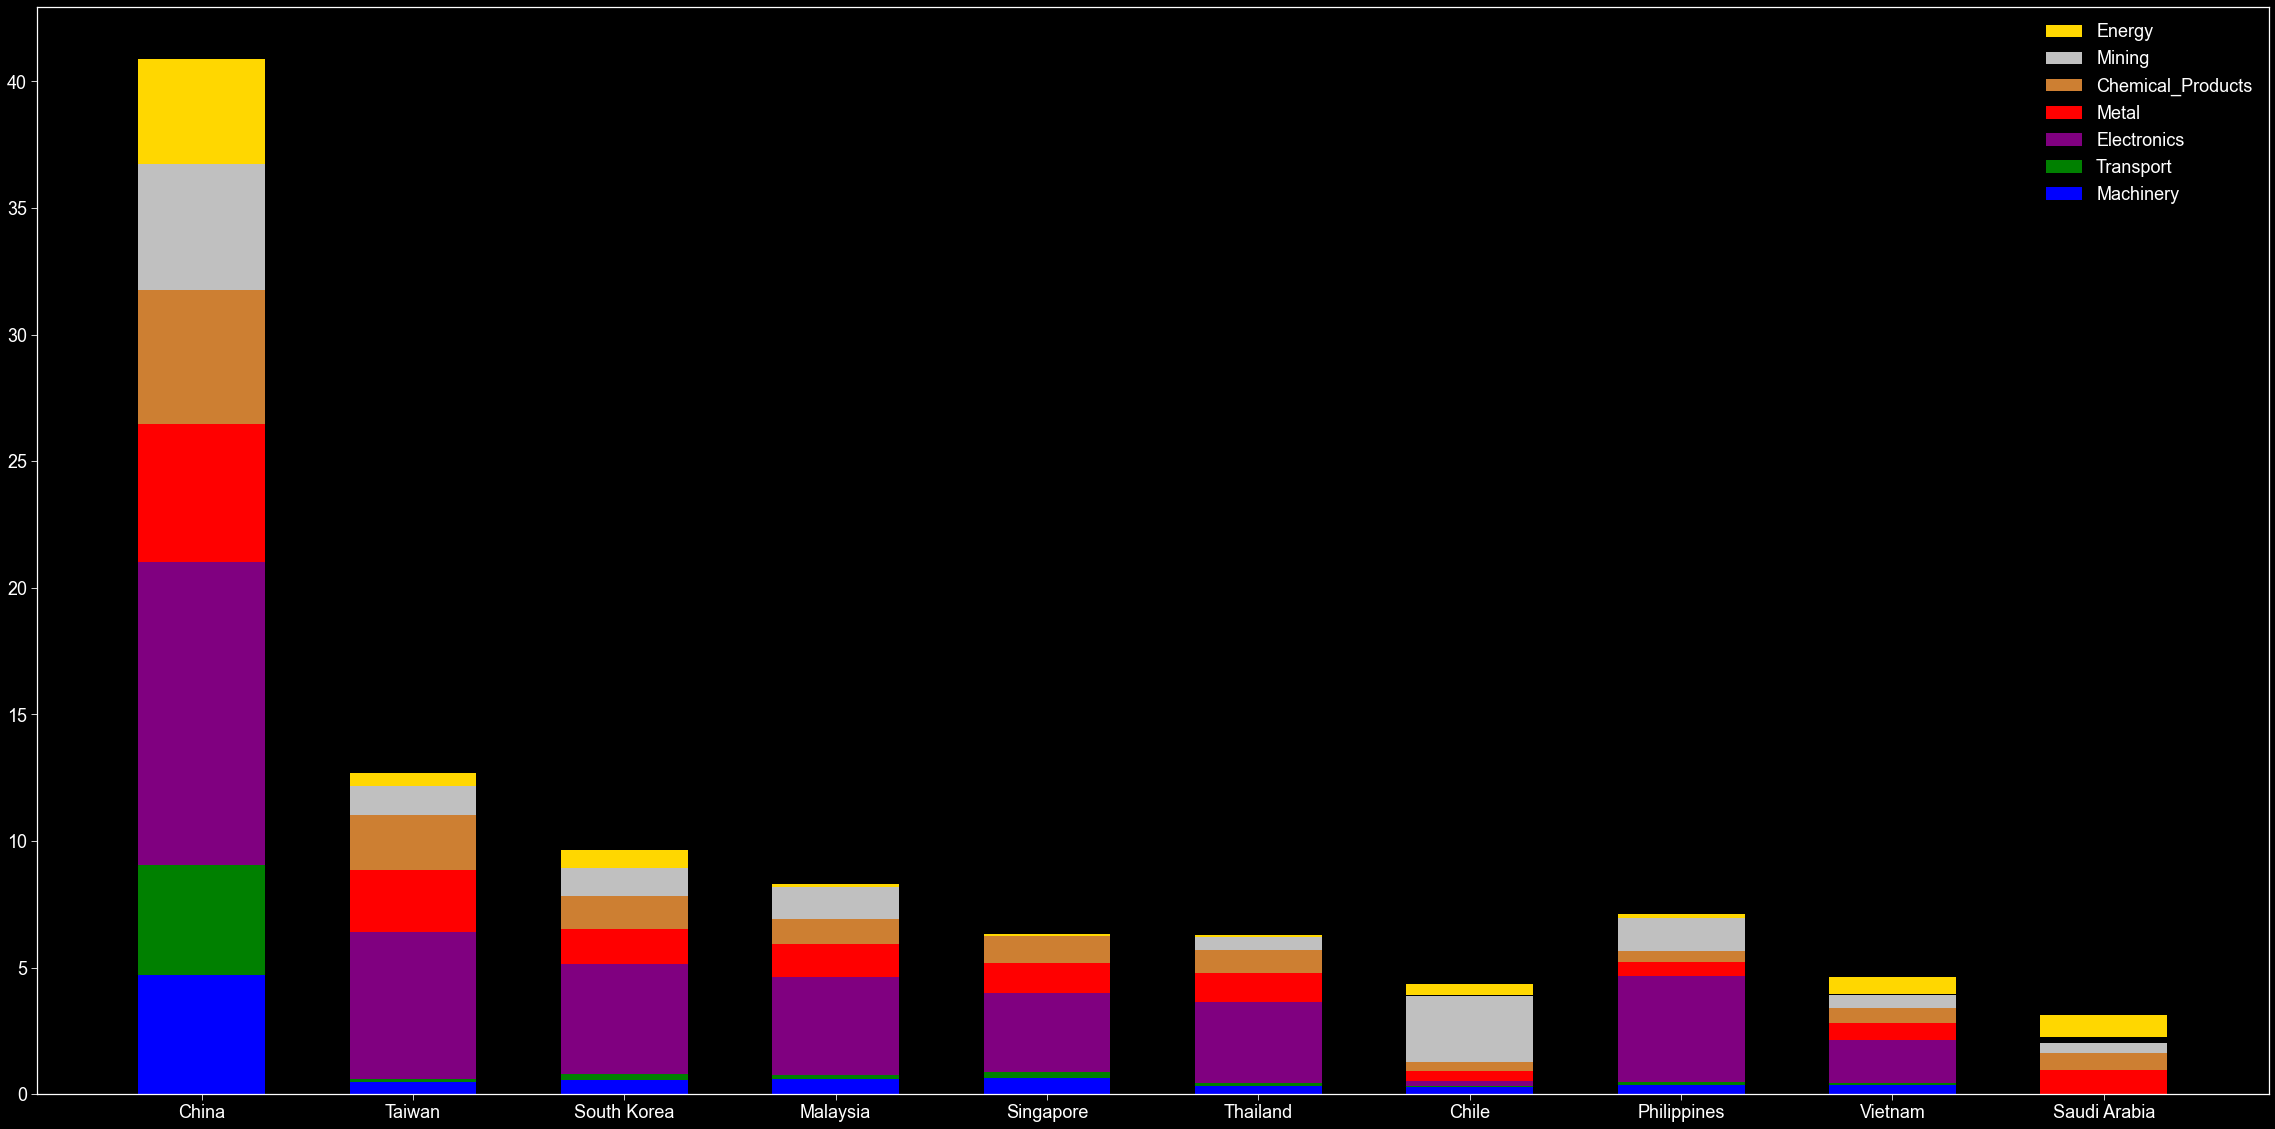

In [16]:
countryIndustry('IndustryCountry.xlsx')

#### It shows that metal, electronics and transport/machinery were most exposed to Chinese exports. We have an idea which business sectors to investigate.

## Automobile Business Sector

In [17]:
#import xlrd for the excel read function
def pieChart(path):
    
    dhData = pd.read_excel(path)
    try:
        connec500 = sqlite3.connect('sp500.db')
    except Error as e:
        print(e)
    
    dhData.to_sql(str(path).strip('.xlsx'), connec500, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None,
                  method=None)
    connec500.commit()
    dhDataSelect = pd.read_sql_query("SELECT * FROM " + str(path).strip('.xlsx'), connec500)
    labels = dhDataSelect['Manufacturer']
    sizes = dhDataSelect['YTD']
    
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    plt.show()

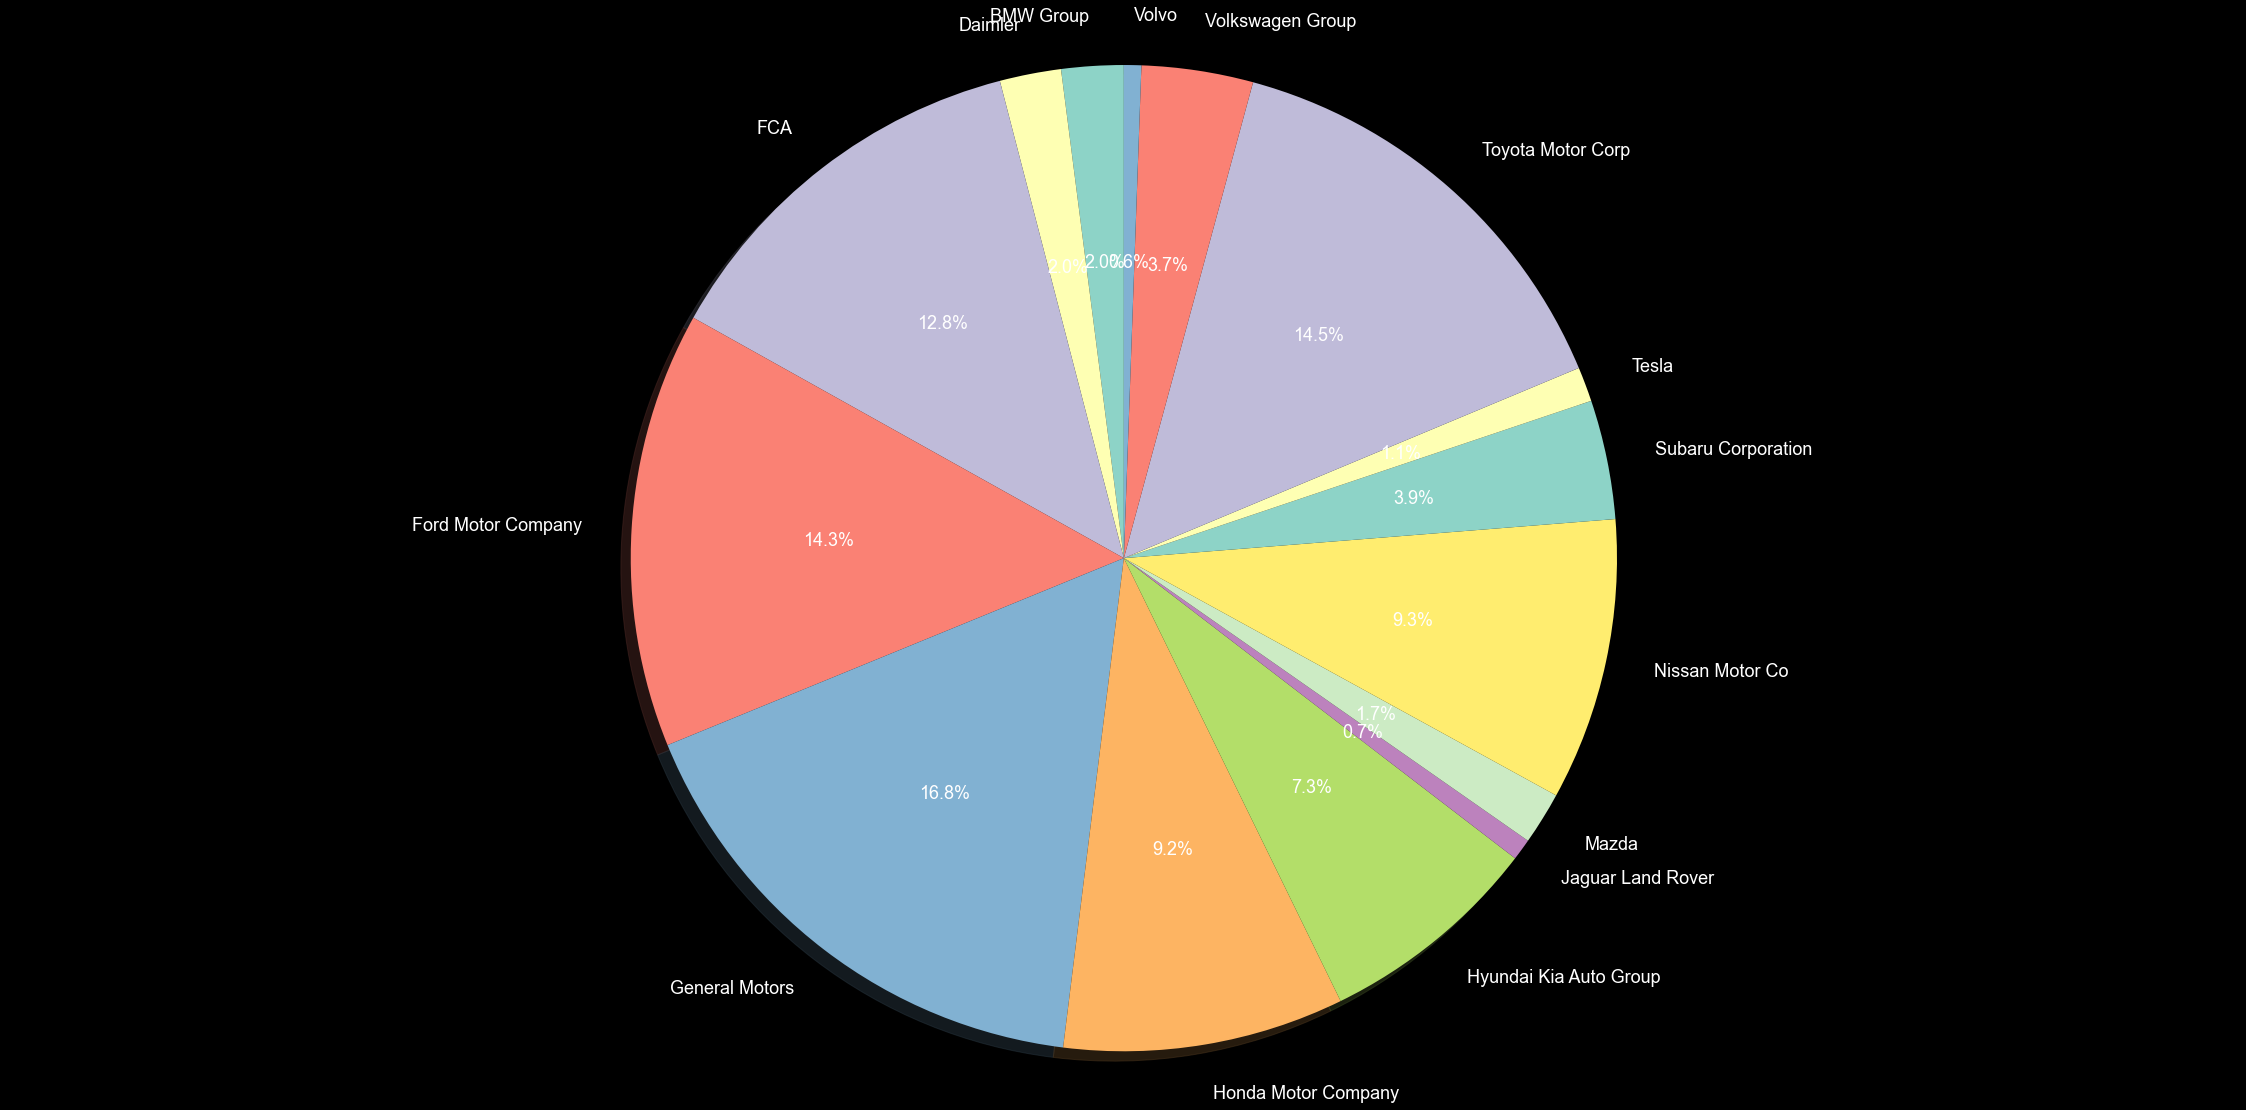

In [18]:
path = 'Automaker.xlsx'
pieChart(path)

#### It shows automobile market shares and we noticed that General Motors (U.S. company) has largest market shares of 16.8 percent, and we also wanted to focus on electronic automobile company such as Tesla (since Tesla is expanding its market into Asia especially China).

### Tesla (NASDAQ: TSLA) and General Motors (NYSE: GM) Stock Trend Line

In [19]:
def compare(c1,c2,start,end):
    start_default = start
    end_default = end
    connec501 = sqlite3.connect('sp500.db')
    connDb = sqlite3.connect('SPdb.db')
    df1 = pd.read_sql_query("SELECT * FROM " + c1 + " WHERE Date BETWEEN '" +str(start_default)+ "' AND '" +str(end_default)+"'", connec501)
    df2 = pd.read_sql_query("SELECT * FROM " + c2 + " WHERE Date BETWEEN '" +str(start_default)+ "' AND '" +str(end_default)+"'", connec501)
    df4 = pd.read_sql_query("SELECT * FROM dates", connDb)
    stocks = pd.DataFrame({'Date':df1['Date'],c1: df1["Adj Close"],c2: df2["Adj Close"]})
    stocks = stocks.set_index(pd.DatetimeIndex(stocks['Date']))
    
    stocks.plot(grid = False,secondary_y = [c2])
    x,y = dropPoints()

In [20]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 11, 11)
company = 'TSLA'
scrapeObj = scrape1()
plotSingle(scrapeObj,start,end,company)

Already DB present


<Figure size 2880x1440 with 0 Axes>

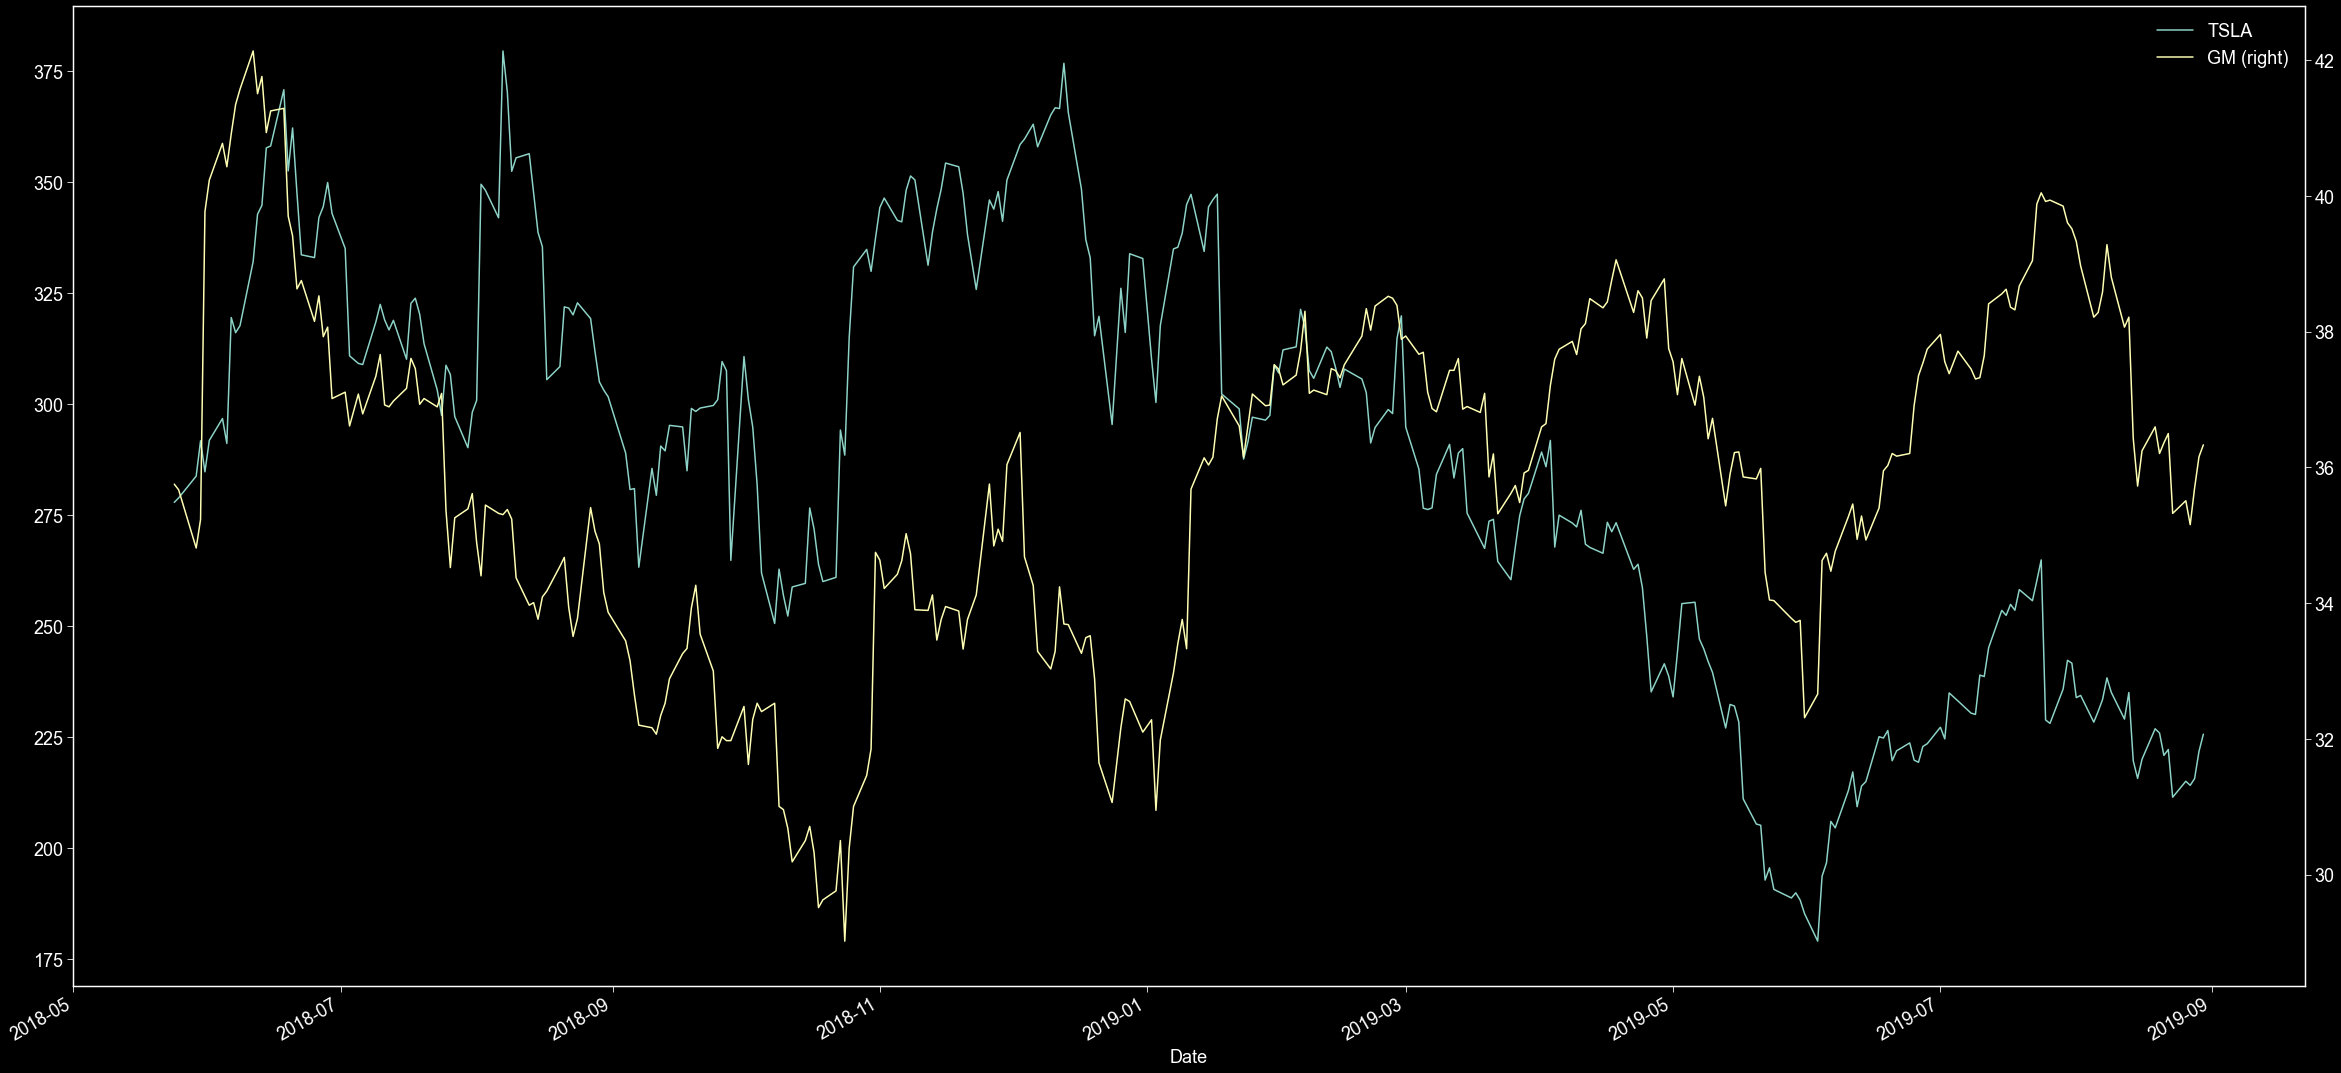

In [21]:
start = dt.datetime(2018, 1, 1)
end = dt.datetime(2019, 8, 30)
compare('TSLA','GM',start,end)

#### It shows that General Motors and Tesla has similar trend line (not consider thier individual stock price) so we decided to use Tesla trend line with dates that president imposed tariffs on China to see if automobile sector took advantage or demaged.

### Tesla (NASDAQ: TSLA) with President Imposed on Tariffs Dates

In [22]:
def dropPointsCom(company,start,end):
    # the database for the dates and the company stock market data is then compared together using the inner join within the 
    # sqlite database of the S&P500 database to display the effect of the trade tarrifs based on the dates   
    
    try:
        conn500 = sqlite3.connect("sp500.db")
            
    except Error as e:
        print(e)
        # create an array of 5 dates starting at '2015-02-24', one per day
    rng = pd.date_range('2019-02-24', periods=20, freq='10D')
    df = pd.DataFrame({ 'Date': rng, 'Val' : np.random.randn(len(rng))})

    df.to_sql('Dates', conn500 , if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None,method=None)
    
    cursor = conn500.cursor()
    
    cursor.execute("SELECT * FROM "+str(company) +" JOIN Dates ON "+str(company)+".Date= Dates.Date")
    ViewData = cursor.fetchall()
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
    conn500.commit()
    date = []
    moving = []
    for i in ViewData:
        date.append(i[0])
        moving.append(i[4])    
    df1 = scrapeObj.sp500_data(company,start,end)
    df1 = df1.set_index(pd.DatetimeIndex(df1['Date']))
    df1.dropna(inplace=True)
    df_ohlc = df1['Adj Close'].resample('2D').ohlc()
    df_ohlc.reset_index(inplace=True)
    
    df_ohlc['Date'] = pd.to_datetime(df_ohlc['Date']).dt.date
    df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
    
    ax1 = plt.subplot2grid((6, 1), (0, 0), rowspan=5, colspan=1)
    ax1.xaxis_date()
    
    ax1.scatter(date, moving, s = 300)
    ax1.plot(df1.index, df1['Adj Close'],linewidth= 2)
    ax1.title.set_text(company + ' Stock Performance')
    ax1.set_xlabel('Date Range')
    ax1.set_ylabel('Stock Price')

Already DB present


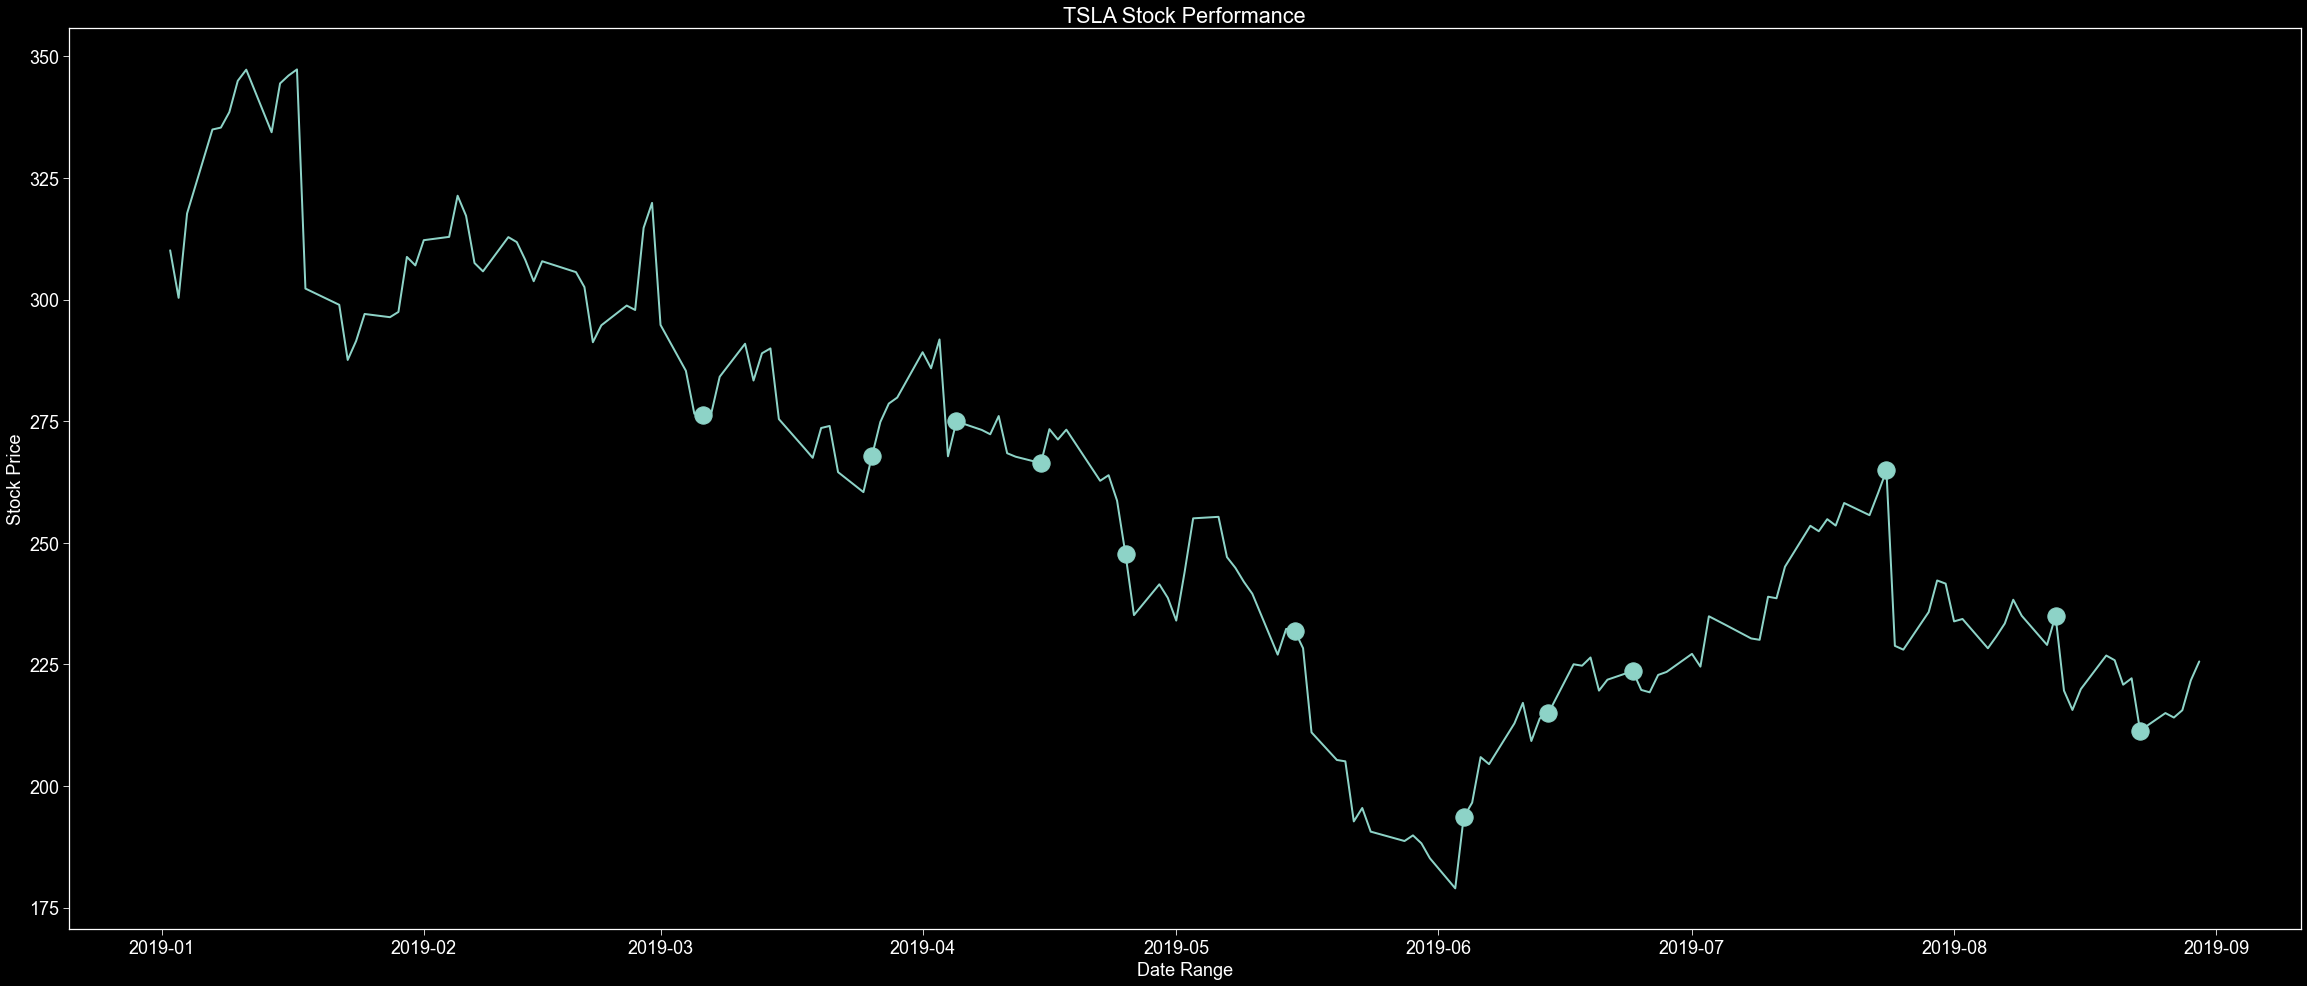

In [23]:
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 8, 30)
company = 'TSLA'
scrapeObj = scrape1()
dropPointsCom(company,start,end)


#### It shows that when president imposed tariffs on Chinese goods, the average trend line decreases.

## Tech Business Sector

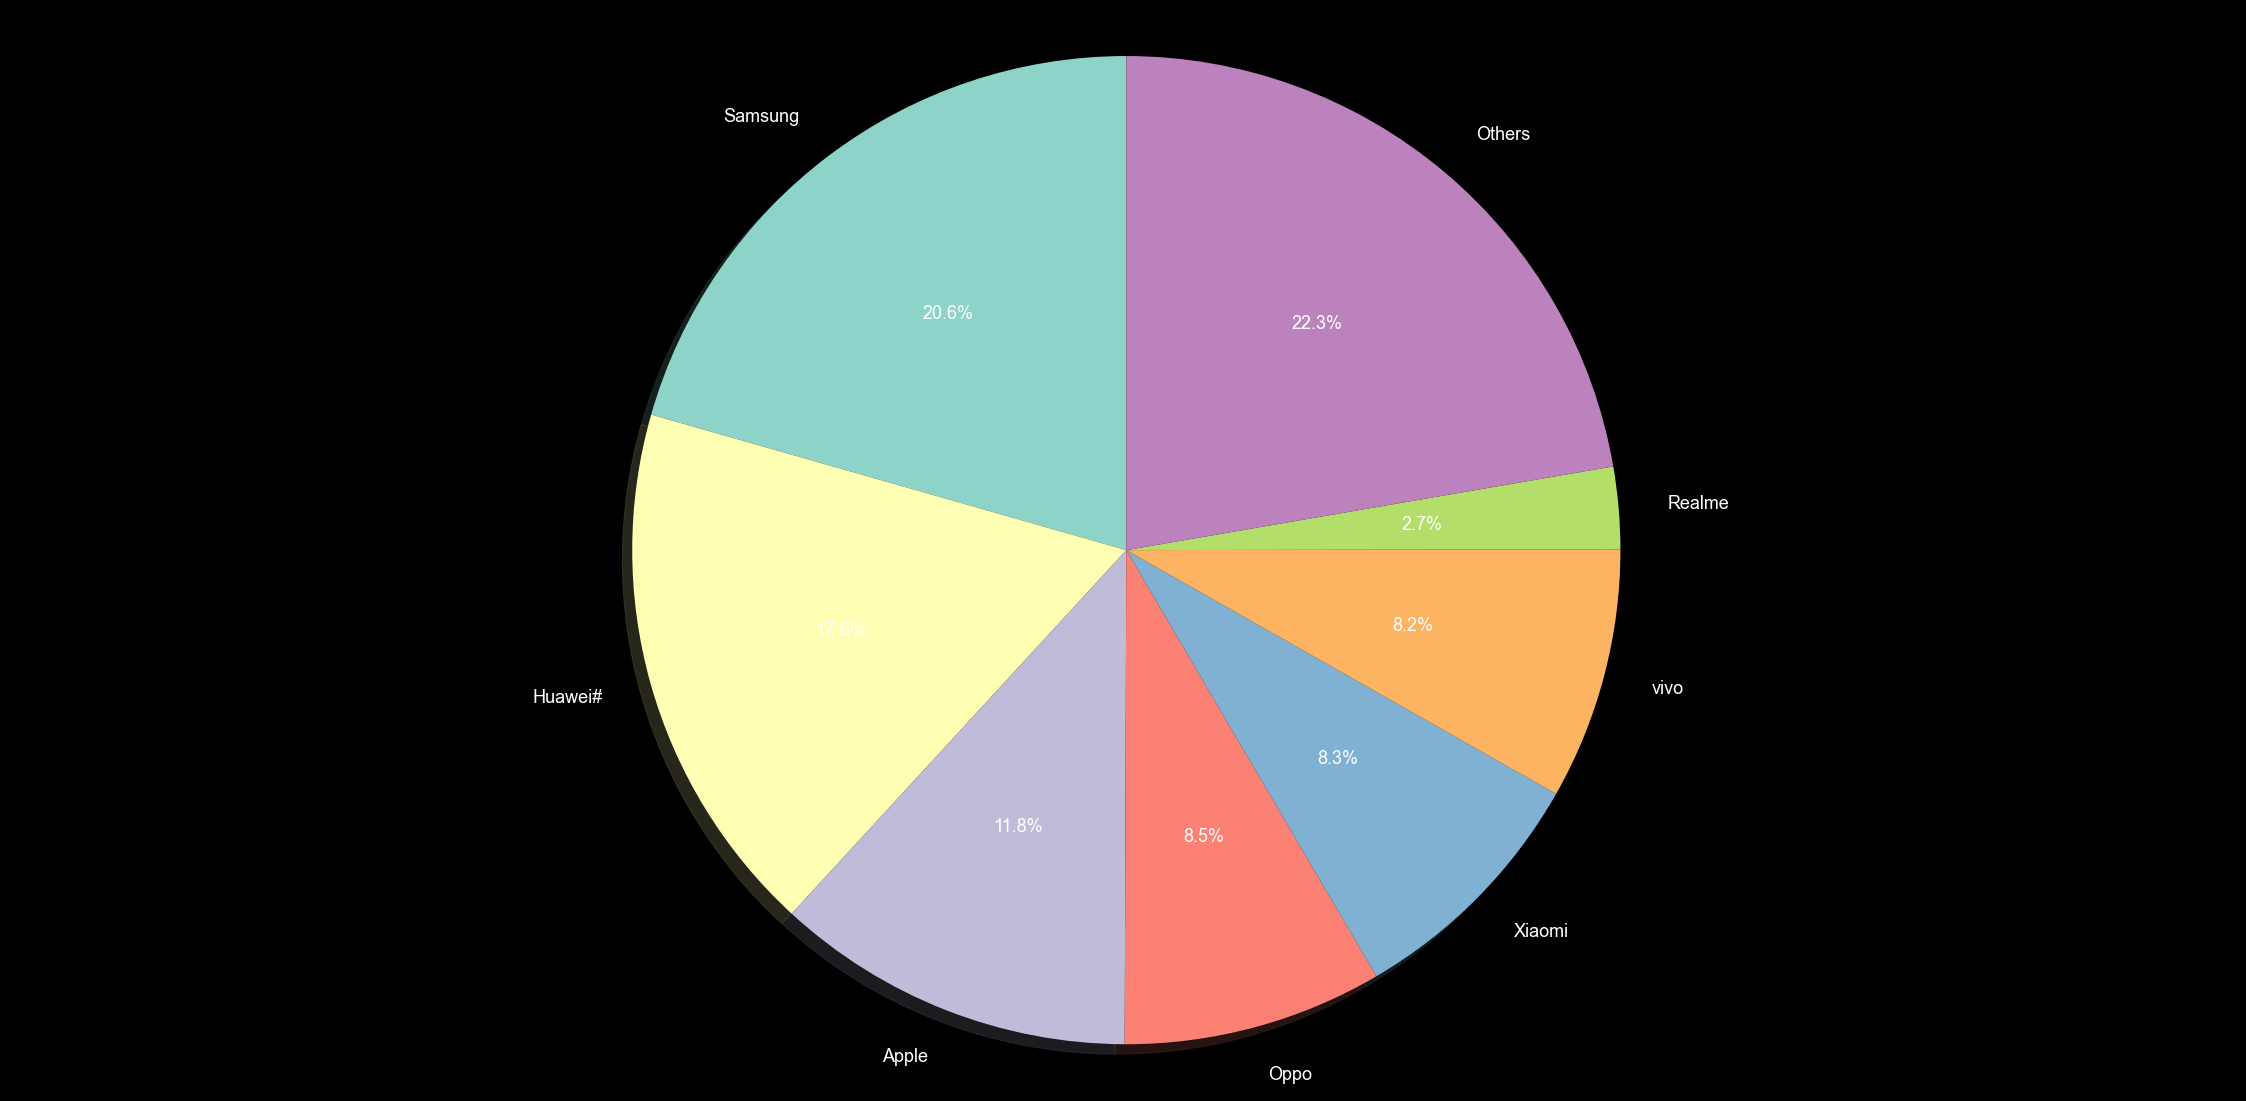

In [24]:
path = 'smartphone_market_share.xlsx'
pieChart(path)

#### It shows that Apple (U.S. company) is one of largest smartphone in the market. We also considered Google Pixel (which included in others) is U.S. company that well-known to the consumers.

### Apple (NASDAQ: AAPL) and General Motors (NASDAQ: GOOGL) Stock Trend Line

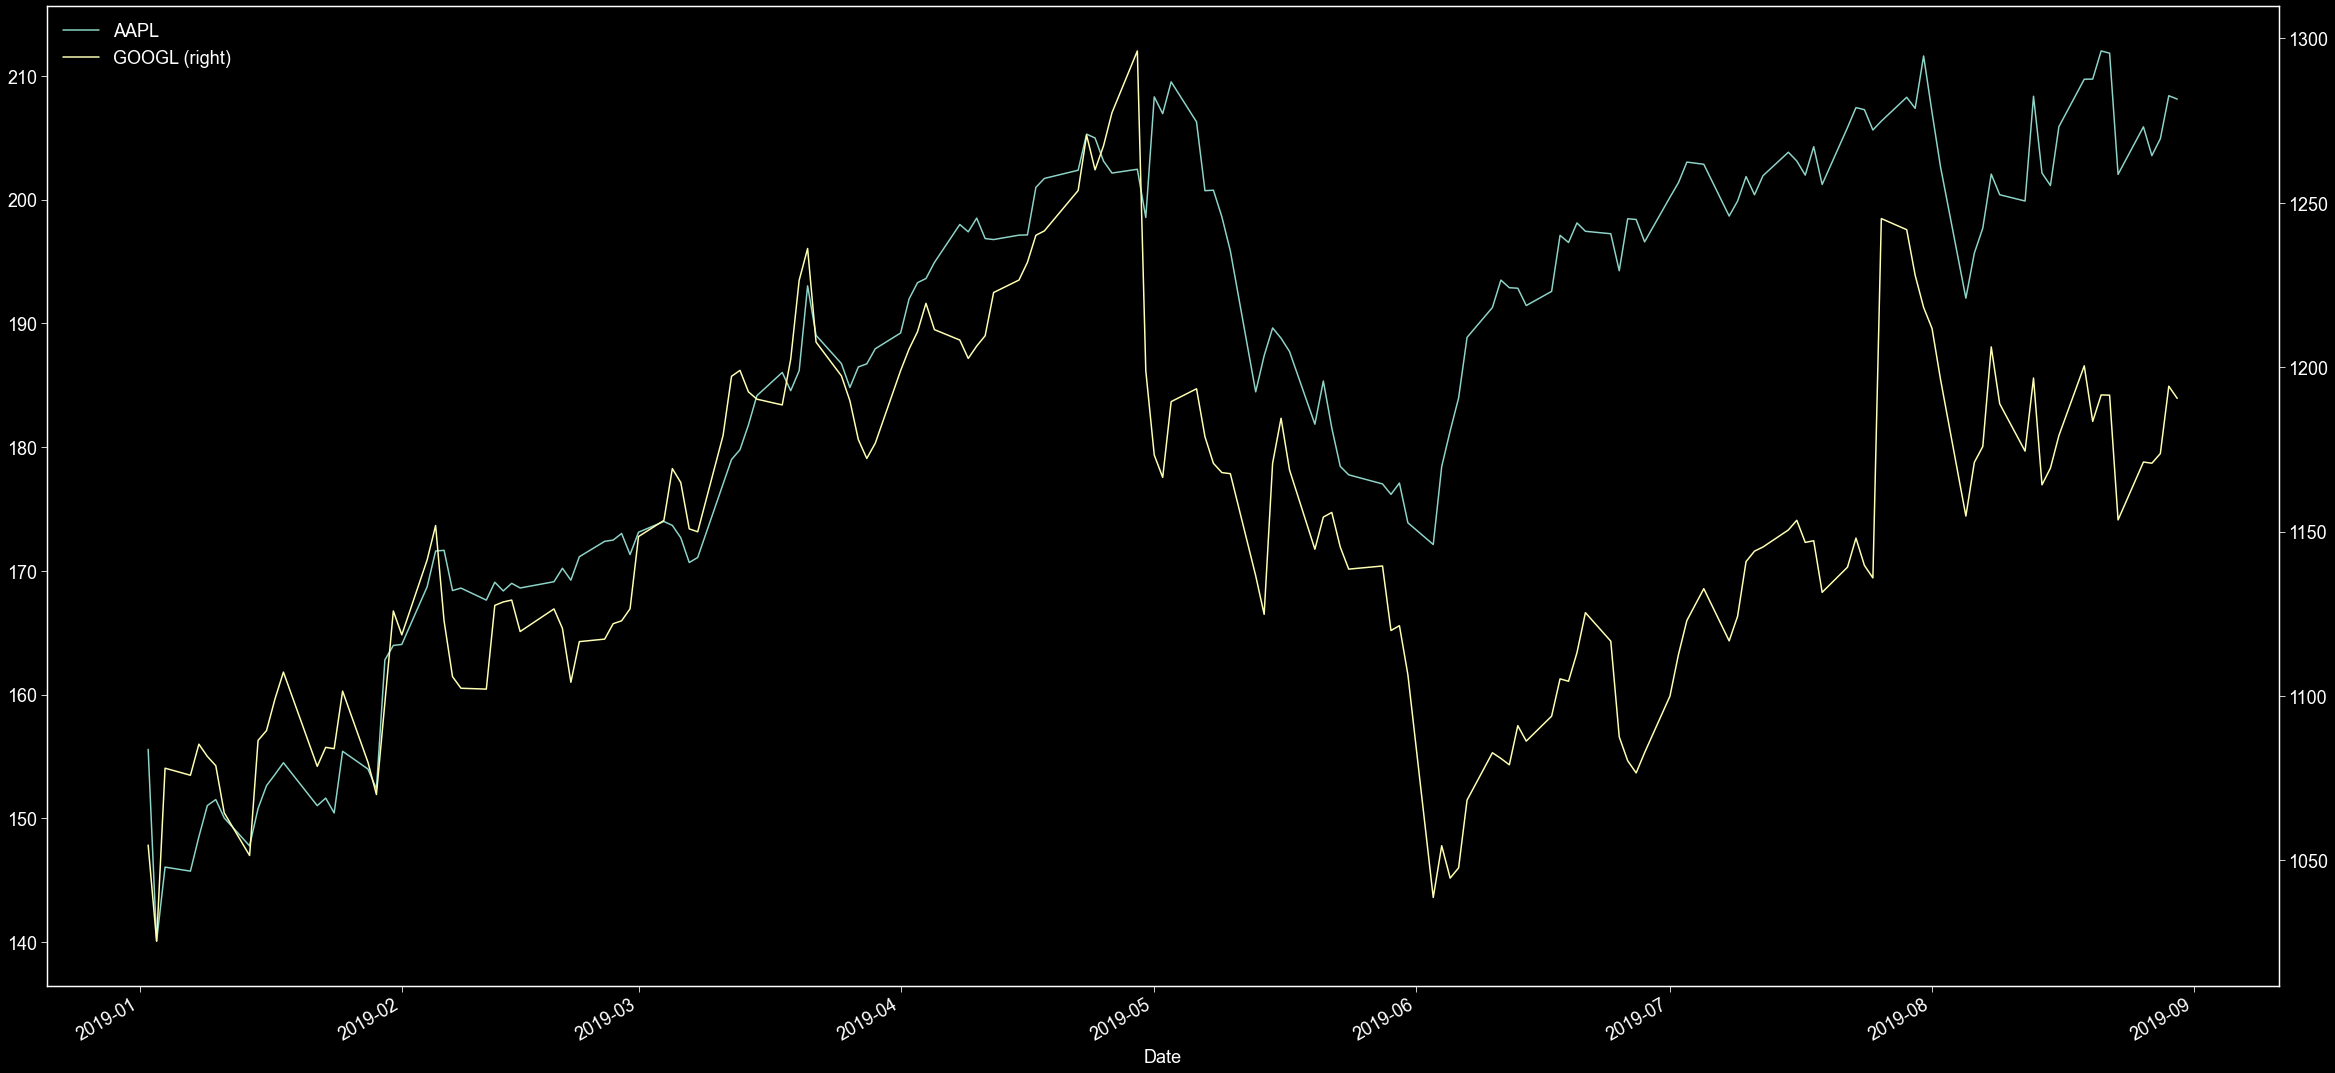

In [25]:
c1 = 'AAPL'
c2 = 'GOOGL'
compare(c1,c2,start,end)

#### It shows that Apple and Google has similar trend line (not consider thier individual stock price) so we decided to use Google trend line with dates that president imposed tariffs on China to see if automobile sector took advantage or demaged.

Already DB present


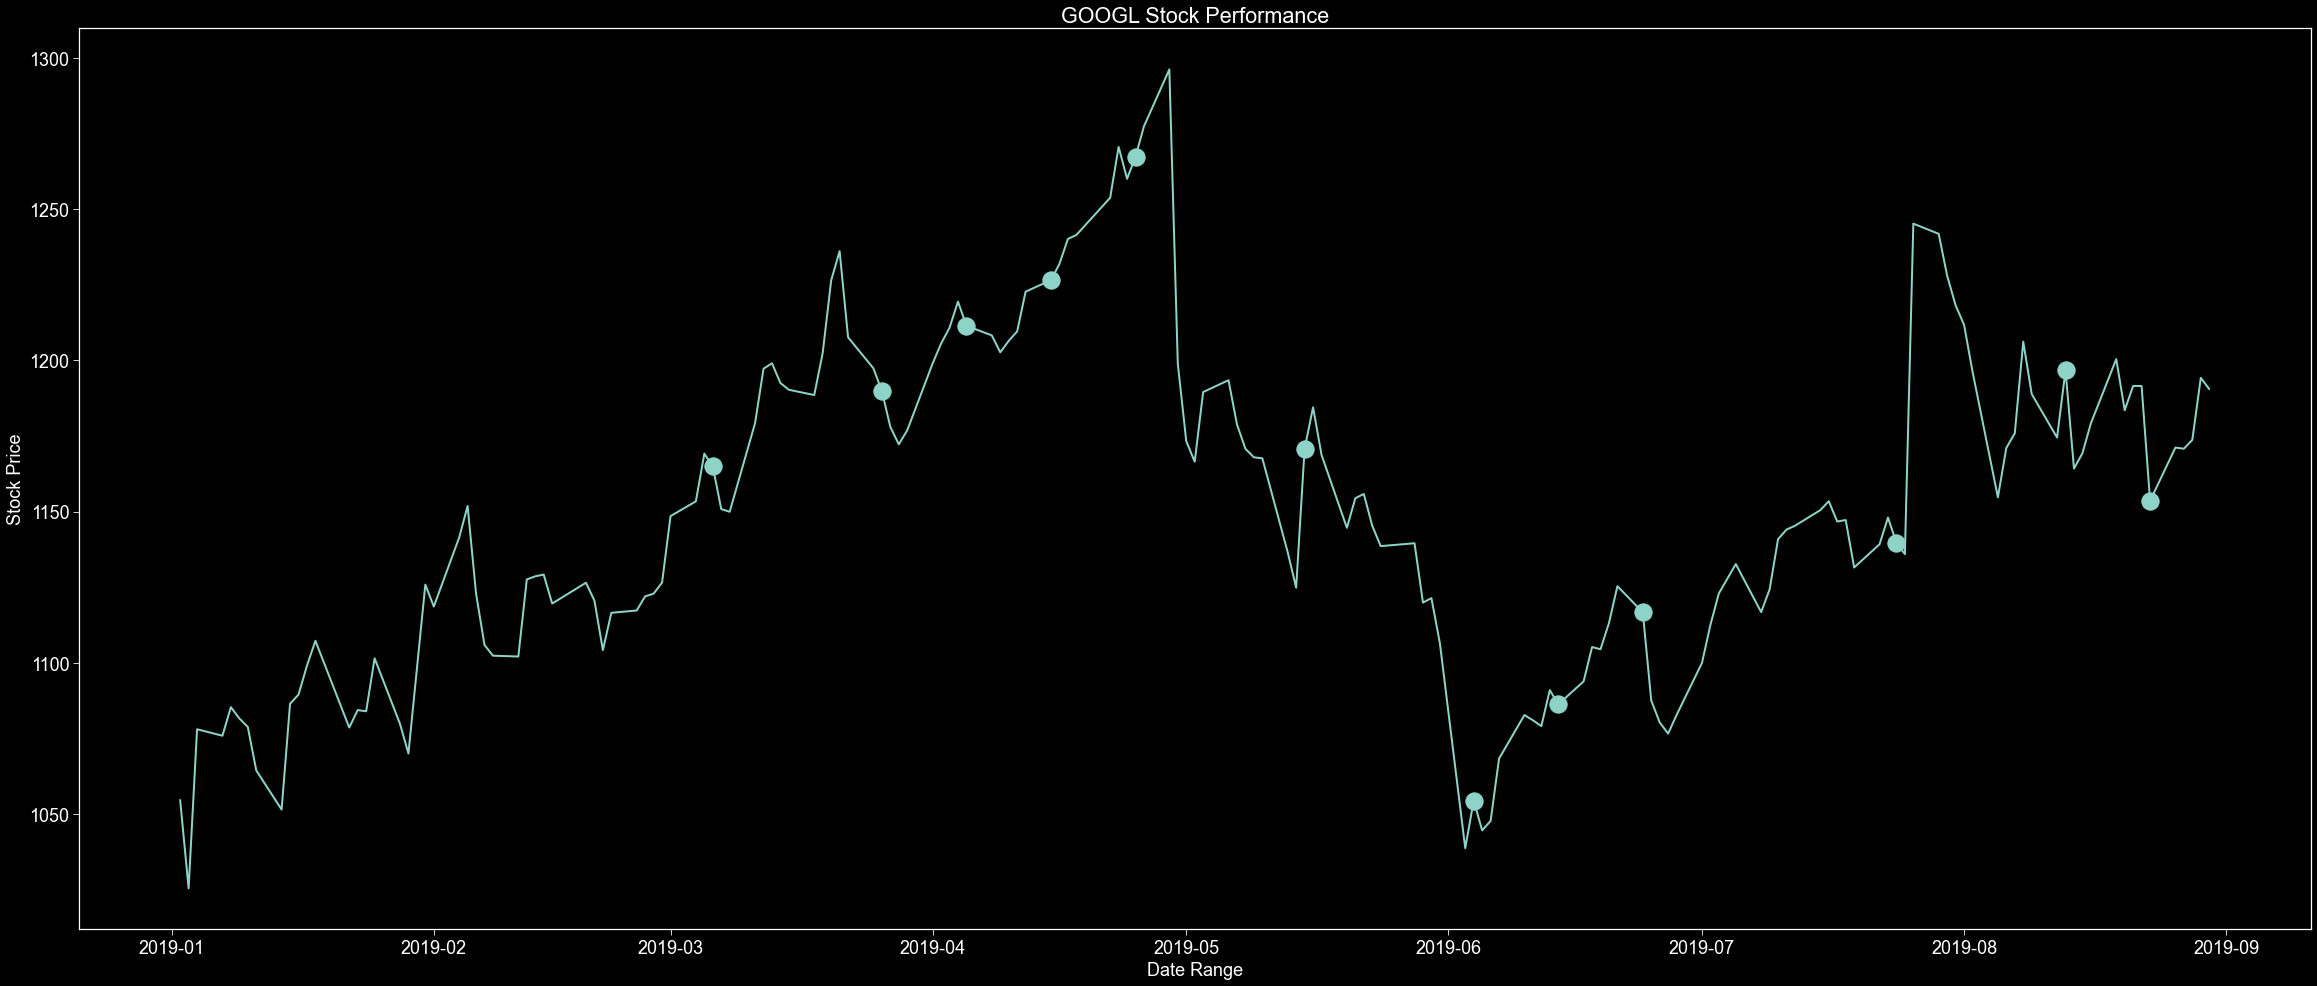

In [26]:
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 8, 30)
company = 'GOOGL'
scrapeObj = scrape1()
dropPointsCom(company,start,end)

#### It shows that when president imposes the tariffs, Google seems taking advantages in the beginning, but the trend line decreases dramatically when it reachese May 2019. Overall, Google suffered from the trade war.

## Material Business Sector
### United States Steel (NTSE: X) Stock Trend Line

Already DB present


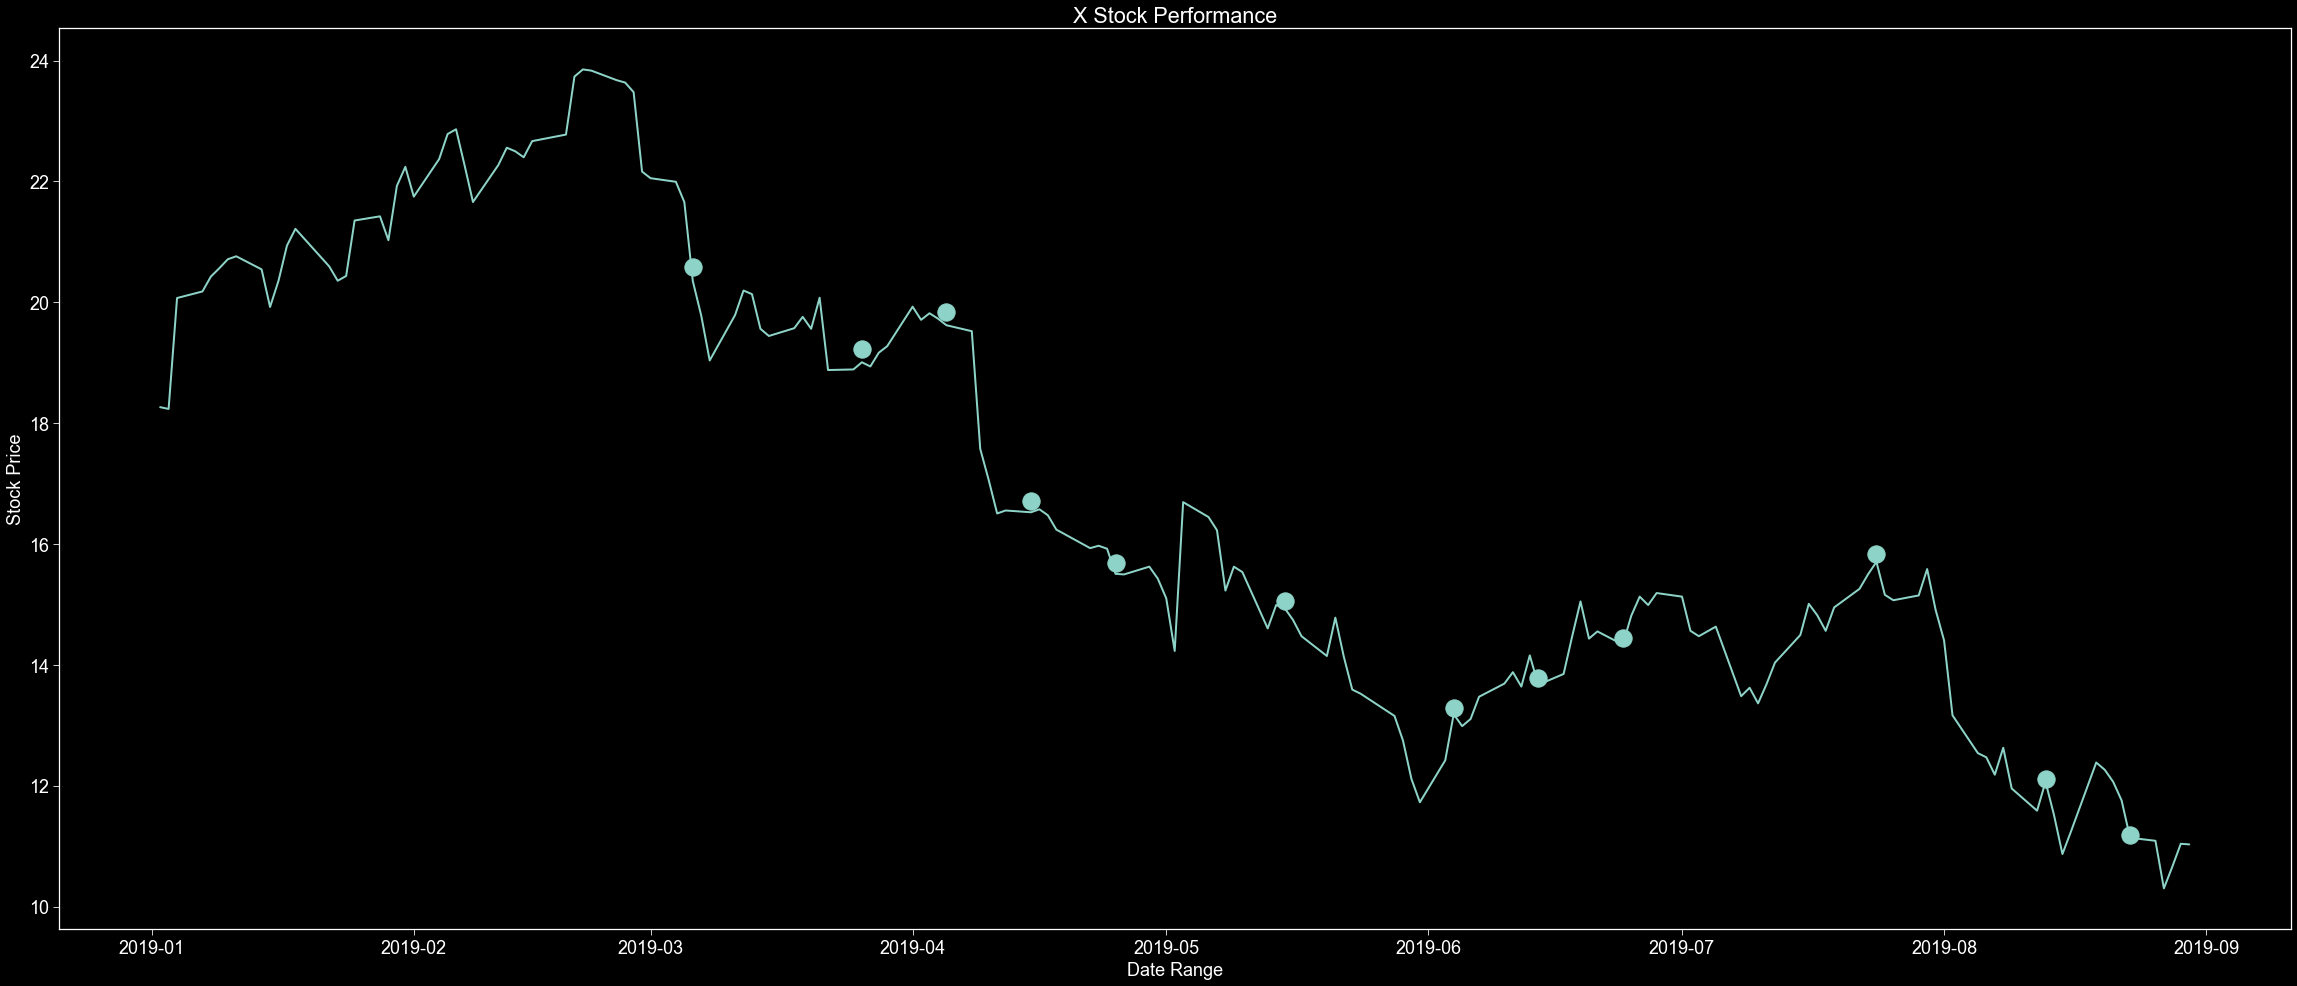

In [27]:
start = dt.datetime(2019, 1, 1)
end = dt.datetime(2019, 8, 30)
company = 'X'
scrapeObj = scrape1()
dropPointsCom(company,start,end)

#### It shows when president impsoes the tariffs, US Steel trend line drops beccause United States of America heavily depends on China (steel and aliminum).

## Conclusion
#### In our conclusion, automobile, tech and material busienss sectors were suffered from the trade war. We think that when the government imposes a high tariff on imported goods, the company indirectly damages its operation due to the increased prices of materials (such as US Steel). If the price of material increases, the corporation has two options, either increase the finished product’s price or decrease the marginal profit. The first option will result in the same net income (each product sold) but the law of supply and demand, when higher the price, the demand will decrease. The second option, when the company decreases the marginal profit, the company will not have the same profit as before (same amount sold) which needs to sell more to reach the same net income as before. The result of both options will loss net income that will affect the balance sheet (equity affected by income statement) and cash flow. These will bring attention to the shareholders to pull back their shares before loss their dividends (or capital income) that affect the balance sheet (equity – a decrease of common stock).